In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [4]:
data = pd.read_csv('Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 1015.8+ KB


In [6]:
data.isnull().sum()

RowNumber          0
CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
data.drop(['RowNumber', 'CustomerId'], axis=1, inplace=True)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
X = data.drop('Exited', axis=1)
y = data['Exited']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numerical_features = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

In [11]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])


In [12]:
# Apply preprocessing and SMOTE
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

In [13]:
# RandomForest Classifier with GridSearchCV
pipeline_rf = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_train_res, y_train_res)

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_preprocessed)
print("Classification Report for RandomForest:\n", classification_report(y_test, y_pred_rf))
roc_value_rf = roc_auc_score(y_test, best_rf.predict_proba(X_test_preprocessed)[:, 1])
print('ROC AUC score for RandomForest:', roc_value_rf)



Classification Report for RandomForest:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      1593
           1       0.63      0.59      0.61       407

    accuracy                           0.85      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.84      0.85      0.84      2000

ROC AUC score for RandomForest: 0.8494110443262985


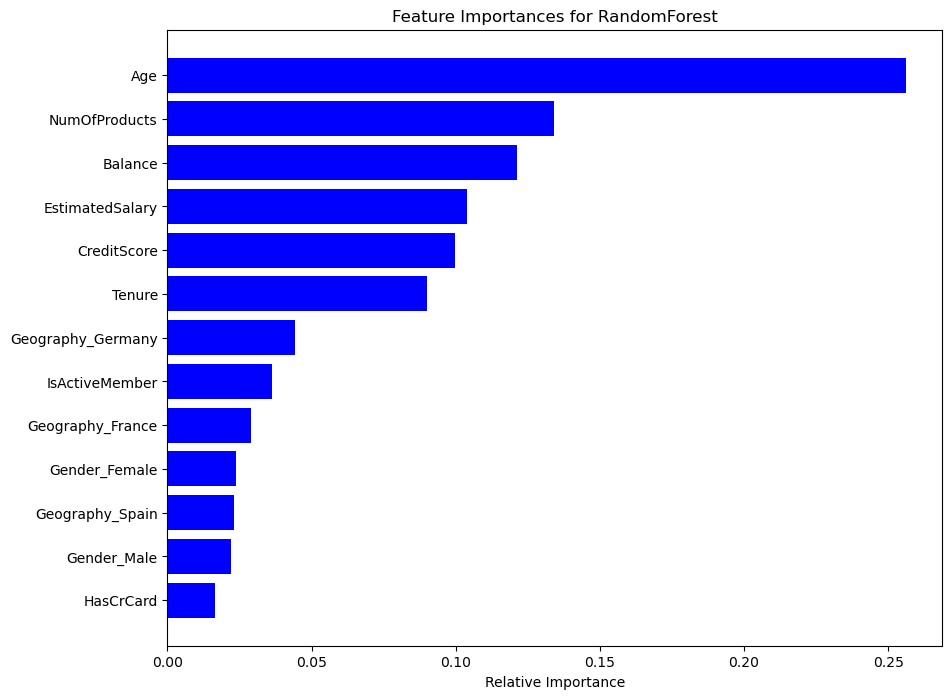

In [14]:
# Feature importances for RandomForest
features_rf = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
importances_rf = best_rf.named_steps['classifier'].feature_importances_
indices_rf = np.argsort(importances_rf)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances for RandomForest')
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], color='b', align='center')
plt.yticks(range(len(indices_rf)), [features_rf[i] for i in indices_rf])
plt.xlabel('Relative Importance')
plt.show()



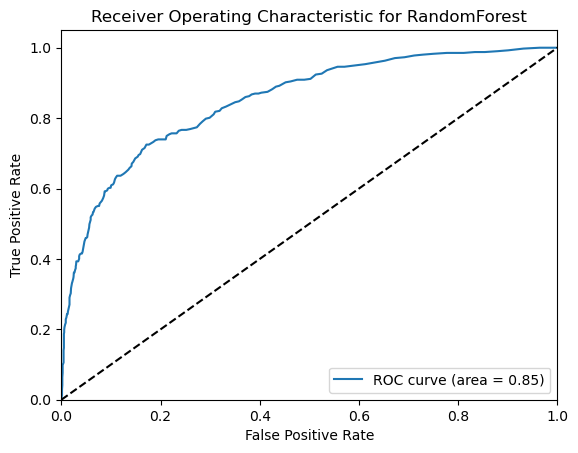

In [15]:
# ROC curve for RandomForest
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf.predict_proba(X_test_preprocessed)[:, 1])
plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f'ROC curve (area = {roc_value_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for RandomForest')
plt.legend(loc="lower right")
plt.show()



In [16]:
# Logistic Regression with GridSearchCV
pipeline_lr = Pipeline(steps=[
    ('classifier', LogisticRegression(random_state=42))
])

param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='roc_auc')
grid_search_lr.fit(X_train_res, y_train_res)

best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_preprocessed)
print("Classification Report for LogisticRegression:\n", classification_report(y_test, y_pred_lr))
roc_value_lr = roc_auc_score(y_test, best_lr.predict_proba(X_test_preprocessed)[:, 1])
print('ROC AUC score for LogisticRegression:', roc_value_lr)



Classification Report for LogisticRegression:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1593
           1       0.39      0.70      0.50       407

    accuracy                           0.72      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.72      0.74      2000

ROC AUC score for LogisticRegression: 0.7755320806168263


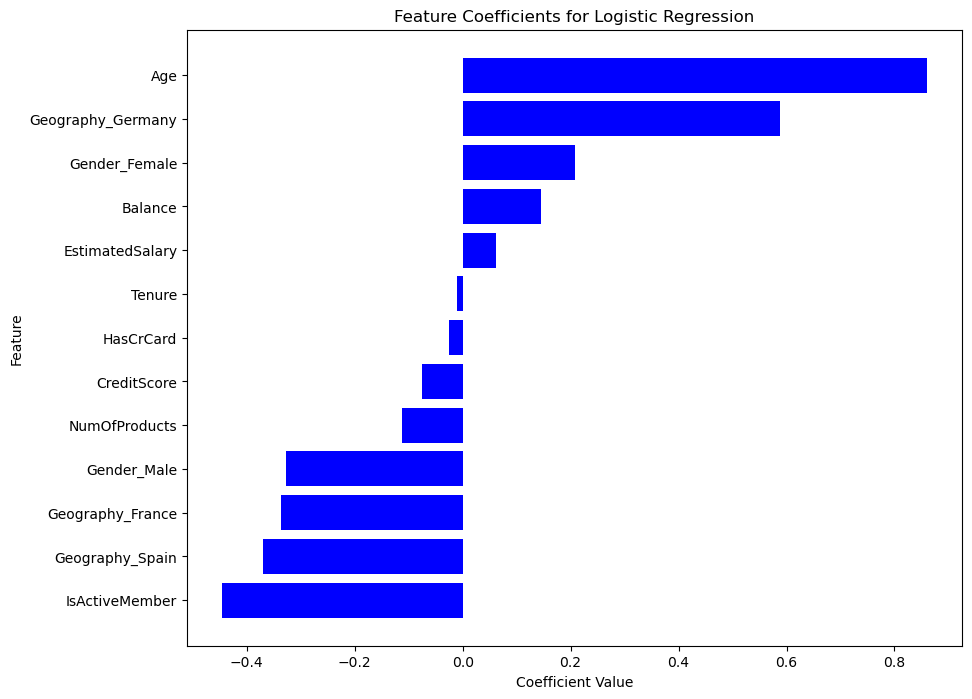

In [17]:
# Feature coefficients for Logistic Regression
coefficients = best_lr.named_steps['classifier'].coef_[0]
features_lr = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
coef_df = pd.DataFrame({'Feature': features_lr, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient')

plt.figure(figsize=(10, 8))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='b')
plt.title('Feature Coefficients for Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()



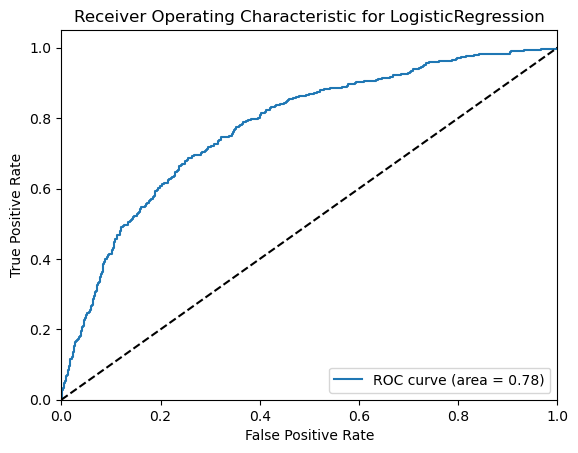

In [18]:
# ROC curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, best_lr.predict_proba(X_test_preprocessed)[:, 1])
plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'ROC curve (area = {roc_value_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LogisticRegression')
plt.legend(loc="lower right")
plt.show()



In [19]:
# XGBoost Classifier with GridSearchCV
pipeline_xgb = Pipeline(steps=[
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.3]
}

grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='roc_auc')
grid_search_xgb.fit(X_train_res, y_train_res)

best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_preprocessed)
print("Classification Report for XGBoost:\n", classification_report(y_test, y_pred_xgb))
roc_value_xgb = roc_auc_score(y_test, best_xgb.predict_proba(X_test_preprocessed)[:, 1])
print('ROC AUC score for XGBoost:', roc_value_xgb)



Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      1593
           1       0.64      0.54      0.58       407

    accuracy                           0.84      2000
   macro avg       0.76      0.73      0.74      2000
weighted avg       0.84      0.84      0.84      2000

ROC AUC score for XGBoost: 0.8366178196686672


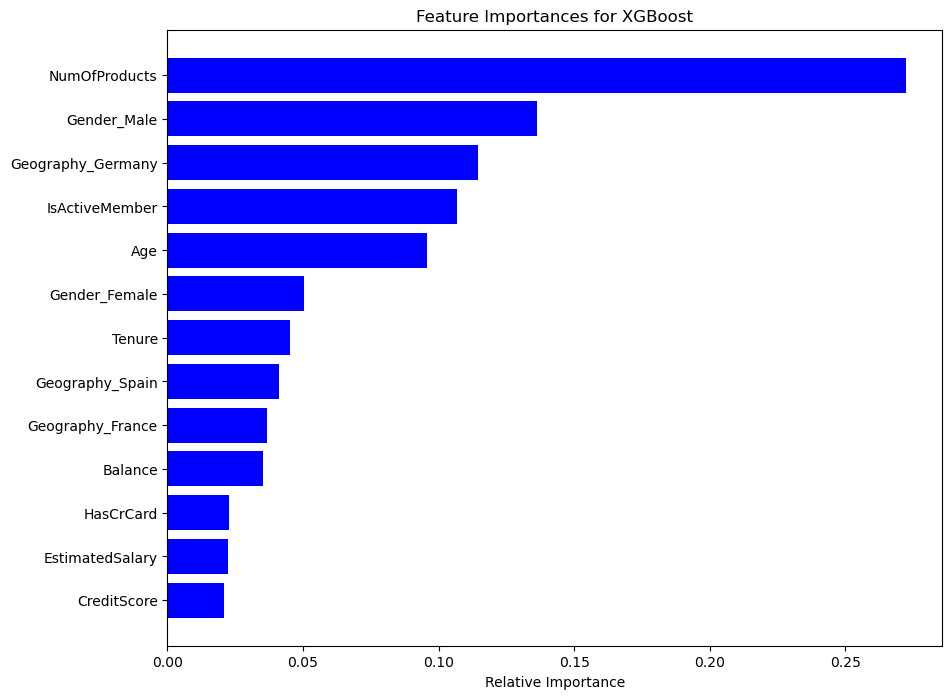

In [20]:
# Feature importances for XGBoost
features_xgb = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
importances_xgb = best_xgb.named_steps['classifier'].feature_importances_
indices_xgb = np.argsort(importances_xgb)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances for XGBoost')
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], color='b', align='center')
plt.yticks(range(len(indices_xgb)), [features_xgb[i] for i in indices_xgb])
plt.xlabel('Relative Importance')
plt.show()



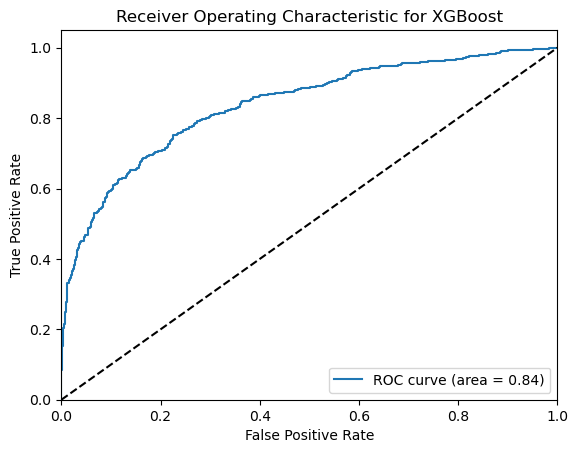

In [21]:
# ROC curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_xgb.predict_proba(X_test_preprocessed)[:, 1])
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f'ROC curve (area = {roc_value_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for XGBoost')
plt.legend(loc="lower right")
plt.show()



In [22]:
# Statistical analysis with statsmodels
X_stat = sm.add_constant(X)
model = sm.Logit(y, X_stat[['const', 'Age', 'Tenure', 'NumOfProducts']])
result = model.fit()
print(result.summary())



Optimization terminated successfully.
         Current function value: 0.466682
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Mon, 29 Jul 2024   Pseudo R-squ.:                 0.07677
Time:                        14:13:33   Log-Likelihood:                -4666.8
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                6.472e-168
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.6011      0.131    -27.479      0.000      -3.858      -3.344
Age               0.

Geography
France     0.161548
Germany    0.324432
Spain      0.166734
Name: Exited, dtype: float64


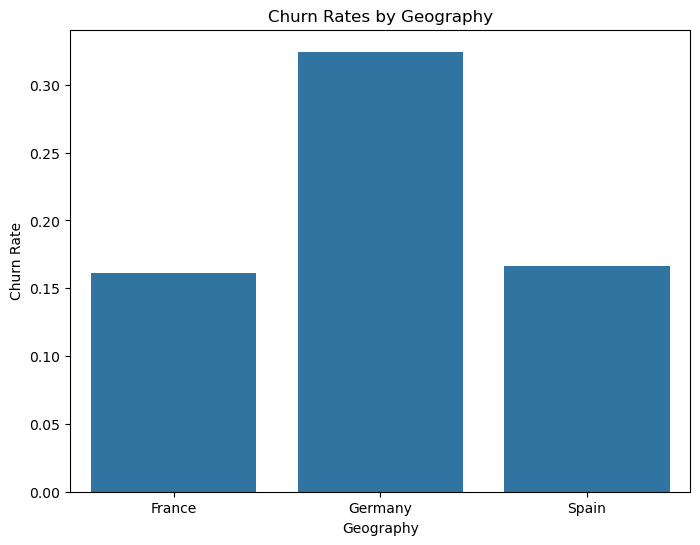

In [23]:
# Churn rate by Geography
churn_rate_region = data.groupby('Geography')['Exited'].mean()
print(churn_rate_region)

plt.figure(figsize=(8, 6))
sns.barplot(x=churn_rate_region.index, y=churn_rate_region.values)
plt.title('Churn Rates by Geography')
plt.ylabel('Churn Rate')
plt.xlabel('Geography')
plt.show()



In [24]:
# Additional statistical analysis
model = sm.Logit(y, X_stat[['const', 'CreditScore']])
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.505122
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 Exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Mon, 29 Jul 2024   Pseudo R-squ.:               0.0007257
Time:                        14:13:35   Log-Likelihood:                -5051.2
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                  0.006757
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.9122      0.168     -5.432      0.000      -1.241      -0.583
CreditScore    -0.0007    